# Basic Walk-Through: Command-Line Interface

This example shows basic usage of `presto` through its command line interface. We'll run a ligand of TYK2 (a common benchmark system for FEP) with the SMILES `CCC(CC)C(=O)Nc2cc(NC(=O)c1c(Cl)cccc1Cl)ccn2`. The entire workflow can be run in a single line (after activating the environment):
```bash
presto train --parameterisation-settings.smiles "CCC(CC)C(=O)Nc2cc(NC(=O)c1c(Cl)cccc1Cl)ccn2"
```
but we'll go through this in more detail below.

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px;">
<strong>Note:</strong> <code>!</code> and <code>%</code> symbols appear before commands in notebook cells to get them to behave as if they were run on the command line. If you're following along, you can ignore them and run the commands directly on the command line.
</div


## Setup

After activating your environment (e.g. with `pixi shell`), navigate to a new directory and use `presto write-default-yaml` to write a default settings file:

In [1]:
! mkdir bespoke-fitting-example-cli
%cd bespoke-fitting-example-cli
! presto write-default-yaml

/home/campus.ncl.ac.uk/nfc78/software/devel/presto/examples/bespoke-fitting-example-cli
2026-01-26 12:43:23.488 | INFO     | presto._cli:cli_cmd:56 - Writing default YAML settings to workflow_settings.yaml.
/home/campus.ncl.ac.uk/nfc78/software/devel/presto/.pixi/envs/default/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `list[str]` - serialized value may not be as expected [input_value='CHANGEME', input_type=str])
  return self.__pydantic_serializer__.to_python(


Have a look at the contents of the `workflow_settings.yaml` file, which comes pre-populated with all of the default settings for every available option:

In [2]:
! cat workflow_settings.yaml

version: 0.2.1.dev1+ged0f63efb.d20260126
output_dir: .
device_type: cuda
n_iterations: 2
memory: false
parameterisation_settings:
    smiles: CHANGEME
    initial_force_field: openff_unconstrained-2.3.0.offxml
    expand_torsions: true
    linearise_harmonics: true
    msm_settings:
        ml_potential: aceff-2.0
        finite_step: 0.0005291772 nm
        tolerance: 0.005291772 kcal * mol**-1 * A**-1
        vib_scaling: 0.958
        n_conformers: 1
    type_generation_settings:
        Bonds:
            max_extend_distance: -1
            include: []
            exclude: []
        Angles:
            max_extend_distance: -1
            include: []
            exclude: []
        ProperTorsions:
            max_extend_distance: -1
            include: []
            exclude:
            - '[*:1]-[*:2]#[*:3]-[*:4]'
            - '[*:1]~[*:2]-[*:3]#[*:4]'
            - '[*:1]~[*:2]=[#6,#7,#16,#15;X2:3]=[*:4]'
        ImproperTorsions:
            max_extend_distance: -1
           

Some particularly important settings are:

 * `smiles` under `parameterisation_settings`. You must tell the program what molecule you want to run!
 *  `ml_potential` under `training_sampling_settings`, `testing_sampling_settings`, and `msm_settings`. The default model is [`aceff-2.0`](https://arxiv.org/abs/2601.00581) which can handle charged and neutral species. Other MLPs, such as `egret-1`, are available.
 * `sampling_protocol` under `training_sampling_settings`. Using `mm_md_metadynamics_torsion_minimisation` means that we will run MD with the molecular mechanics (`mm_md`) force field and use well-tempered metadynamics on rotatable bonds to enhance sampling (`metadynamics`) . We also mix in structures from very short minimisations (`torsion_minimisation`) using the MLP to introduce structures closer to the MLP potential energy surface which may be missed with purely MM sampling (for example configurations with strong clashes). The minimisations are short enough that there is little relaxation of the torisons.

 Change the SMILES and any other settings you'd like in the yaml file.

In [3]:
! sed -i 's/  smiles: CHANGEME/  smiles: "CCC(CC)C(=O)Nc2cc(NC(=O)c1c(Cl)cccc1Cl)ccn2"/' workflow_settings.yaml

Now we're ready to run!

## Execution

Run the fitting with `presto train-from-yaml`. This takes around 20 minutes with a GPU and a few hours on CPUs.

In [4]:
! presto train-from-yaml workflow_settings.yaml

2026-01-26 12:53:29.211 | INFO     | presto._cli:cli_cmd:41 - Running presto with settings from workflow_settings.yaml
2026-01-26 12:53:29.461 | INFO     | presto.create_types:add_types_to_forcefield:392 - Generated 39 bespoke SMARTS patterns for handler Bonds across 1 molecules.
2026-01-26 12:53:29.485 | INFO     | presto.create_types:add_types_to_forcefield:392 - Generated 64 bespoke SMARTS patterns for handler Angles across 1 molecules.
2026-01-26 12:53:29.523 | INFO     | presto.create_types:add_types_to_forcefield:392 - Generated 86 bespoke SMARTS patterns for handler ProperTorsions across 1 molecules.
2026-01-26 12:53:29.580 | INFO     | presto.create_types:add_types_to_forcefield:392 - Generated 15 bespoke SMARTS patterns for handler ImproperTorsions across 1 molecules.
2026-01-26 12:53:29.657 | DEBUG    | presto.create_types:_remove_redundant_smarts:187 - Removed unused parameter b-bespoke-94 with SMIRKS [#6&!H0&!H1&!H2:1]-[#6&!H0&!H1:2]-[#6&!H0](-[#6&!H0&!H1]-[#6&!H0&!H1&!H2])

## Analysis

We now have a bespoke force field: check out `training_iteration_2/bespoke_ff.offxml`. Have a look for the bespoke types at the end of each section:

In [8]:
! cat training_iteration_2/bespoke_ff.offxml

<?xml version="1.0" encoding="utf-8"?>
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <Author>The Open Force Field Initiative</Author>
    <Date>2026-01-02</Date>
    <Constraints version="0.3">
        <Constraint smirks="[#1:1]-[#8X2H2+0:2]-[#1]" id="c-tip3p-H-O" distance="0.9572 * angstrom ** 1"></Constraint>
        <Constraint smirks="[#1:1]-[#8X2H2+0]-[#1:2]" id="c-tip3p-H-O-H" distance="1.5139006545247014 * angstrom ** 1"></Constraint>
    </Constraints>
    <vdW version="0.4" potential="Lennard-Jones-12-6" combining_rules="Lorentz-Berthelot" scale12="0.0" scale13="0.0" scale14="0.5" scale15="1.0" cutoff="9.0 * angstrom ** 1" switch_width="1.0 * angstrom ** 1" periodic_method="cutoff" nonperiodic_method="no-cutoff">
        <Atom smirks="[#1:1]" epsilon="0.0157 * kilocalorie ** 1 * mole ** -1" id="n1" rmin_half="0.6 * angstrom ** 1"></Atom>
        <Atom smirks="[#1:1]-[#6X4]" epsilon="0.01336628116185 * kilocalorie ** 1 * mole ** -1" id="n2" rmin_half="1.495082

We can check out the standard plots to get more information on how well the fitting has gone and how the parameters have changed -- take a look in `plots`:

In [6]:
! ls plots

correlation_mol0.png		    loss.png
error_distributions_mol0.png	    parameter_differences_mol0.png
force_error_by_atom_index_mol0.png  parameter_values_mol0.png


For example, `loss.png` displays how the training loss (computed on the training set) and the test loss (computed on a seperate set of samples generated with the MLP) changes during training at each iteration (indexed from 0). Our loss looks reasonably well-converged.

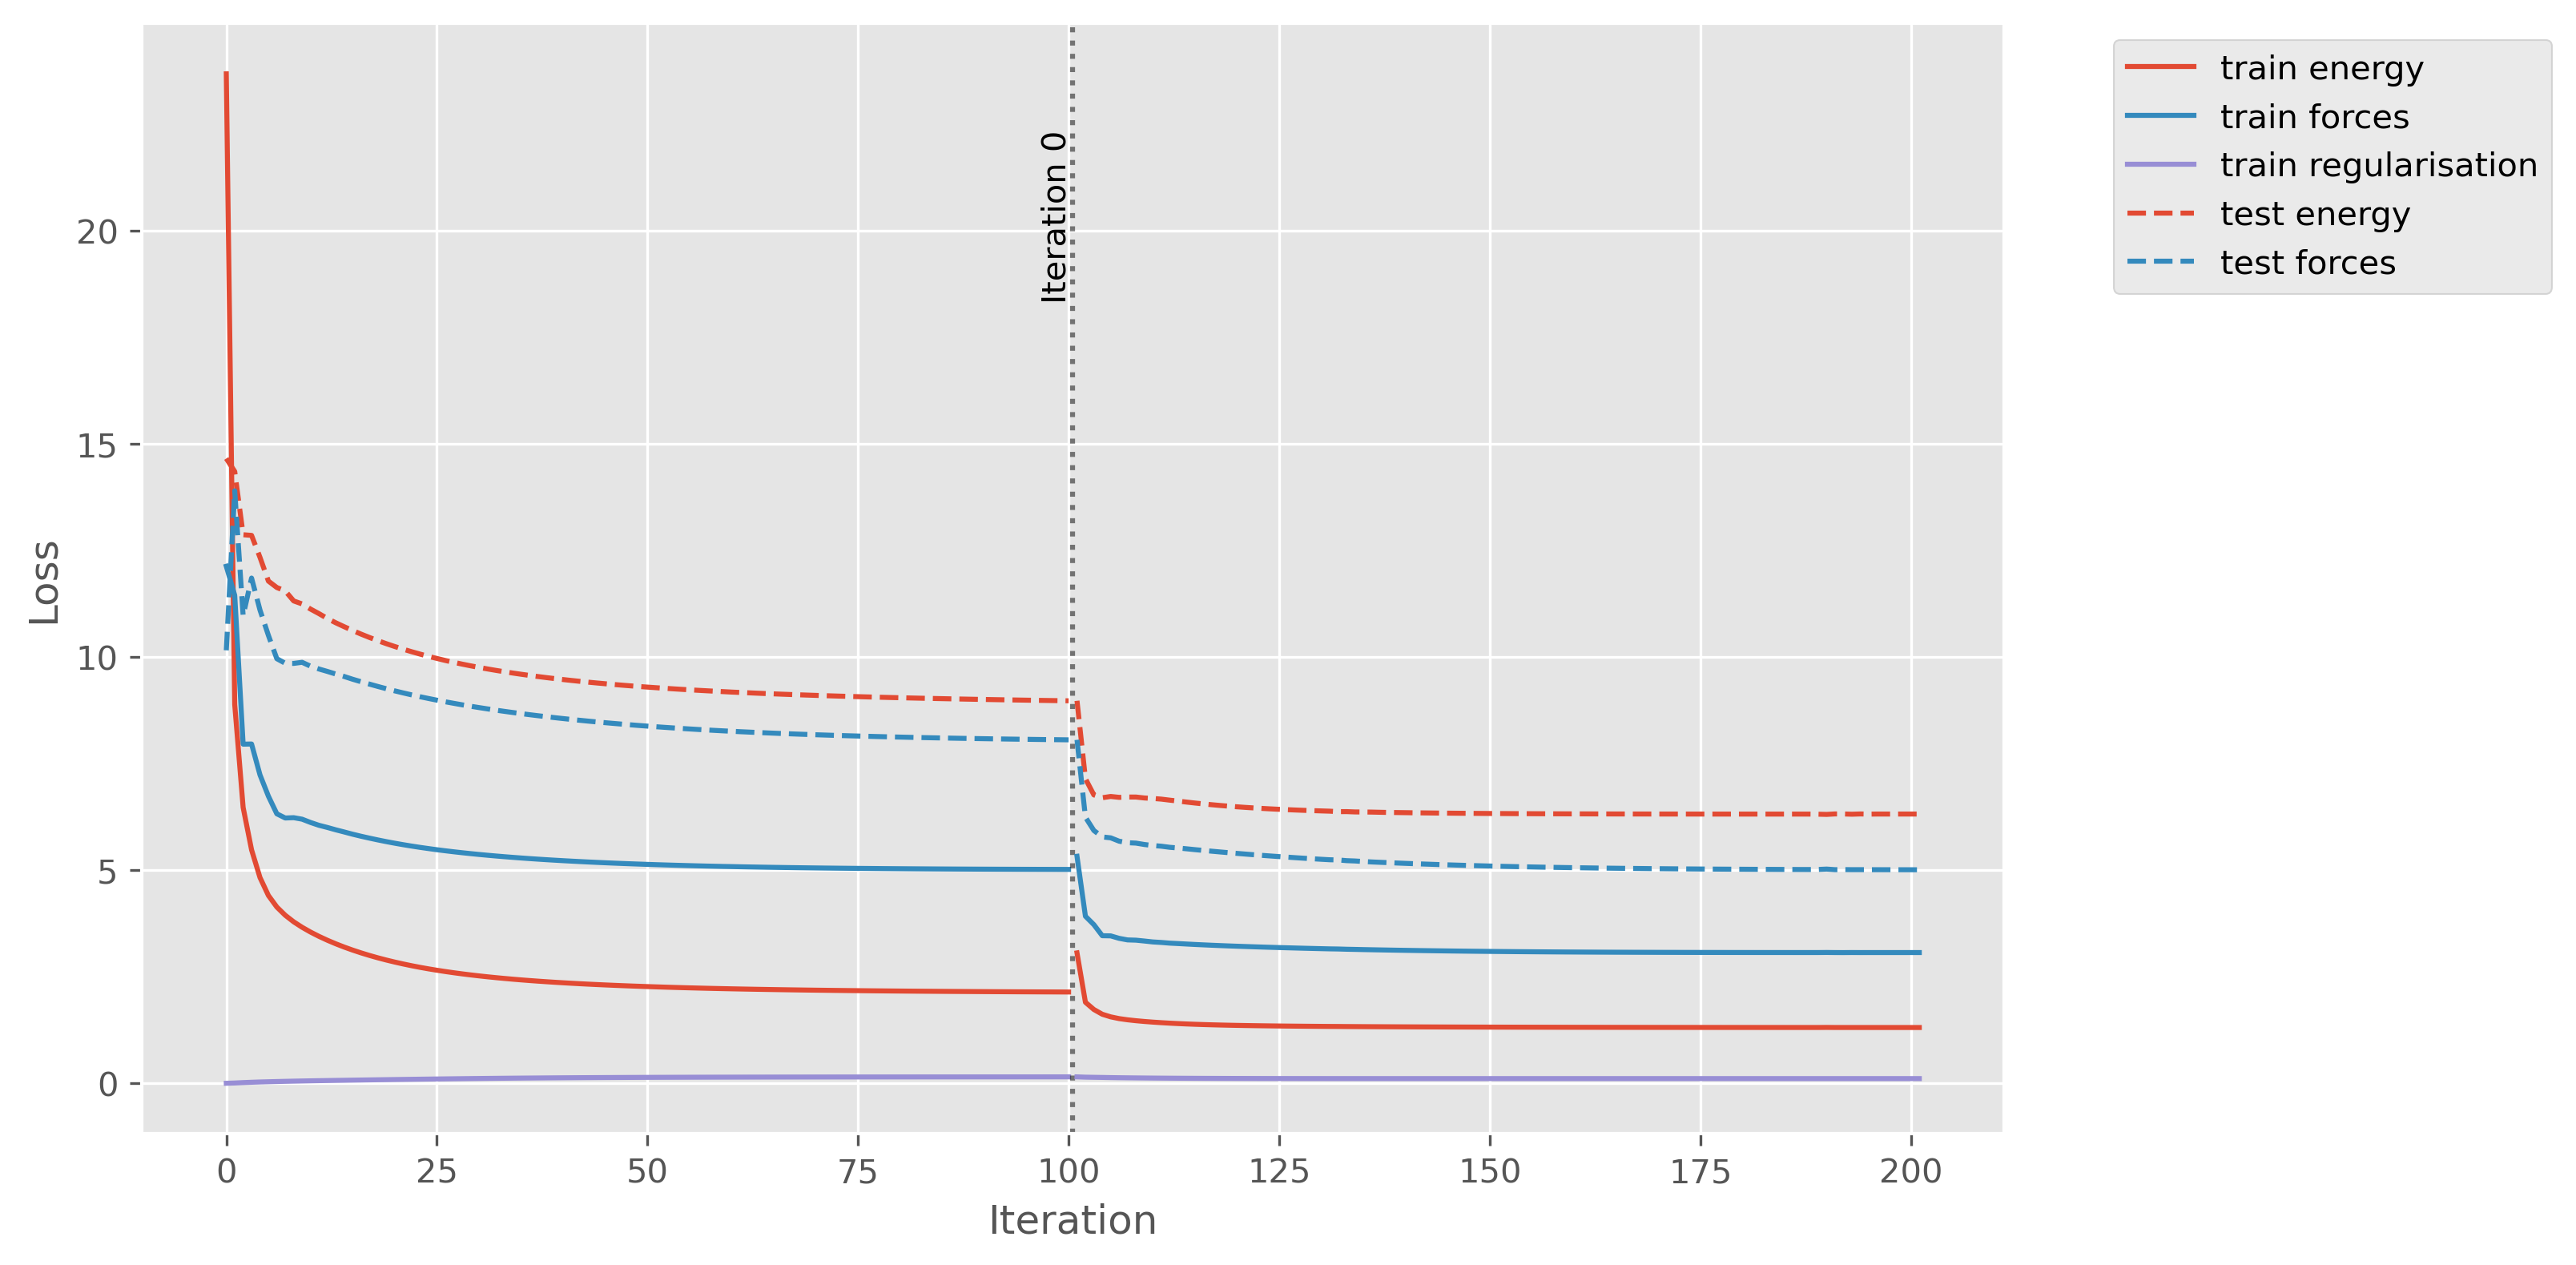

In [7]:
from IPython.display import Image, display

display(Image(filename='plots/loss.png'))

## Using your bespoke force field

Now we have our bespoke force field, we can use it in our intended application. As a quick illustration, we can easily run some vacuum MD with OpenFF's Toolkit and Interchange packages, and OpenMM. First, we can create an `Interchange` object which contains all of the information requied to start molecular dynamics.

In [9]:
from openff.toolkit import Molecule, ForceField, Topology

force_field = ForceField('training_iteration_2/bespoke_ff.offxml')
molecule = Molecule.from_smiles('CCC(CC)C(=O)Nc2cc(NC(=O)c1c(Cl)cccc1Cl)ccn2')
molecule.generate_conformers(n_conformers=1)

interchange = force_field.create_interchange(molecule.to_topology())

Now we can run MD with OpenMM:

In [10]:
import openmm
import openmm.unit
from openff.interchange import Interchange
import mdtraj
import nglview


def run_openmm(
    interchange: Interchange,
    reporter_frequency: int = 1000, # Decrease this to save more frames!
    trajectory_name: str = "small_mol_solvated.pdb",
):
    simulation = interchange.to_openmm_simulation(
        integrator=openmm.LangevinMiddleIntegrator(
            300 * openmm.unit.kelvin,
            1 / openmm.unit.picosecond,
            0.002 * openmm.unit.picoseconds,
        ),
    )

    pdb_reporter = openmm.app.PDBReporter(trajectory_name, reporter_frequency)
    simulation.reporters.append(pdb_reporter)

    simulation.context.setVelocitiesToTemperature(300 * openmm.unit.kelvin)
    simulation.runForClockTime(10 * openmm.unit.second)


def visualise_traj(
    topology: Topology, filename: str = "small_mol_solvated.pdb"
) -> nglview.NGLWidget:
    """Visualise a trajectory using nglview."""
    traj = mdtraj.load(
        filename,
        top=mdtraj.Topology.from_openmm(topology.to_openmm()),
    )

    view = nglview.show_mdtraj(traj)
    view.add_representation("licorice", selection="water")

    return view


run_openmm(interchange)
visualise_traj(interchange.topology)

NGLWidget(max_frame=431)

## Cleaning up

To remove all files created by `presto`, you can run `presto clean workflow_settings.yaml`. This does not remove `workflow_settings.yaml`, rather uses it to find the expected files and remove them. This will raise an error and exit if it comes across any files it did not generate in directories it would otherwise delete.

In [11]:
! presto clean workflow_settings.yaml

2026-01-26 13:25:17.644 | INFO     | presto._cli:cli_cmd:76 - Cleaning output directory with settings from workflow_settings.yaml
